#  <center> Speech Emotion Recognition <center>
#### Machine Learning Term Project
#### DATS 6202


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### The term project for the Machine Learning course focuses on building a speech emotion detection classifier.

#### Let's understand the SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition (SER) involves identifying human emotions and affective states through speech, utilizing the fact that variations in tone and pitch often reveal one's emotions. This concept is similar to how animals such as dogs and horses interpret human emotions through vocal sounds.

#### The requirement of SER:

1. Emotion recognition is becoming an increasingly popular and necessary component of speech recognition technology. While traditional methods employ machine learning techniques to detect emotions, this project leverages deep learning to analyze emotional data.

2. Speech Emotion Recognition (SER) is utilized in call centers to categorize calls based on emotional content. This serves as a metric for evaluating conversation quality, helping identify unsatisfied customers and overall customer satisfaction, thereby aiding companies in enhancing their services.

3. Additionally, SER can be integrated into vehicle systems to monitor the driver's mental state. This information can then be used to activate safety measures, potentially preventing accidents.

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D):
https://www.kaggle.com/datasets/ejlok1/cremad
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess): https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
* Surrey Audio-Visual Expressed Emotion (Savee):https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee

# Importing Libraries

In [ ]:
pip install sndfile

  Preparing metadata (setup.py) ... done
  Created wheel for sndfile: filename=sndfile-0.2.0-cp310-cp310-linux_x86_64.whl size=25500 sha256=14a57f9a797d3346e5b0e75be2c556104e431c49ba0794ecfcecd17fb73df748
  Stored in directory: /root/.cache/pip/wheels/3f/3f/2e/f11101320ffd30664f25d92fae93758ab798e4f90e97cc8d59
Successfully built sndfile


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It is utilized to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
* As we are working with 3 different datasets, we will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* Further, this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/ml_project/Audio_Speech_Actors_01-24/"
Crema = "/content/drive/MyDrive/ml_project/cremad/AudioWAV/"
Savee = "/content/drive/MyDrive/ml_project/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
The filename identifiers as per the official RAVDESS website:
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  disgust  /content/drive/MyDrive/ml_project/Audio_Speech...
1     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
2     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
3     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
4  neutral  /content/drive/MyDrive/ml_project/Audio_Speech...

## <center>2. Crema DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /content/drive/MyDrive/ml_project/cremad/Audio...
1  neutral  /content/drive/MyDrive/ml_project/cremad/Audio...
2    angry  /content/drive/MyDrive/ml_project/cremad/Audio...
3  disgust  /content/drive/MyDrive/ml_project/cremad/Audio...
4    happy  /content/drive/MyDrive/ml_project/cremad/Audio...

##  <center> 3. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0       sad  /content/drive/MyDrive/ml_project/surrey-audio...
1  surprise  /content/drive/MyDrive/ml_project/surrey-audio...
2   disgust  /content/drive/MyDrive/ml_project/surrey-audio...
3   neutral  /content/drive/MyDrive/ml_project/surrey-audio...
4   neutral  /content/drive/MyDrive/ml_project/surrey-audio...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  disgust  /content/drive/MyDrive/ml_project/Audio_Speech...
1     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
2     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
3     calm  /content/drive/MyDrive/ml_project/Audio_Speech...
4  neutral  /content/drive/MyDrive/ml_project/Audio_Speech...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

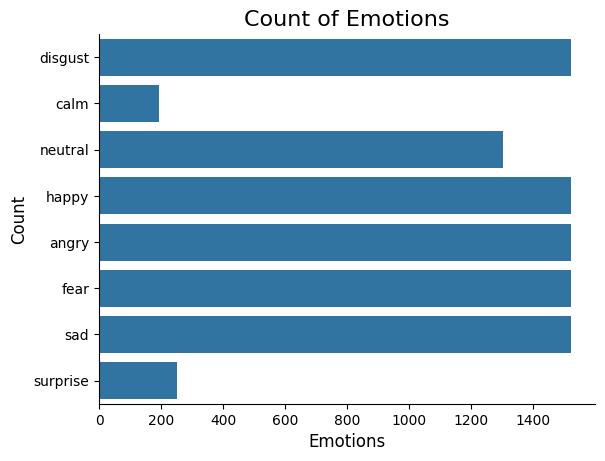

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

It can be observed that the emotions Happy, Angry, Disgust, Fear, and Sad have the equivalent counts, followed by Neutral, Surprise, and Calm.

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

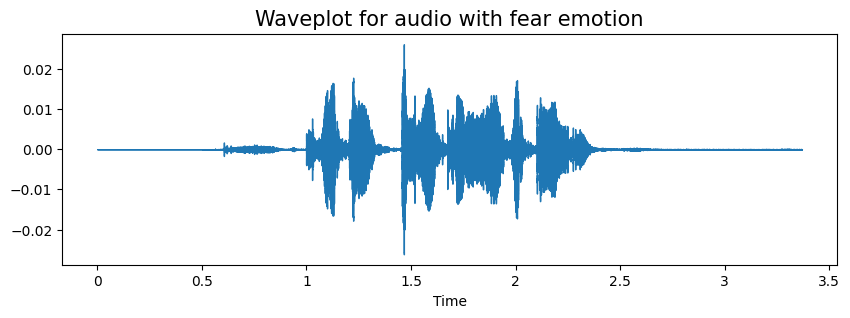

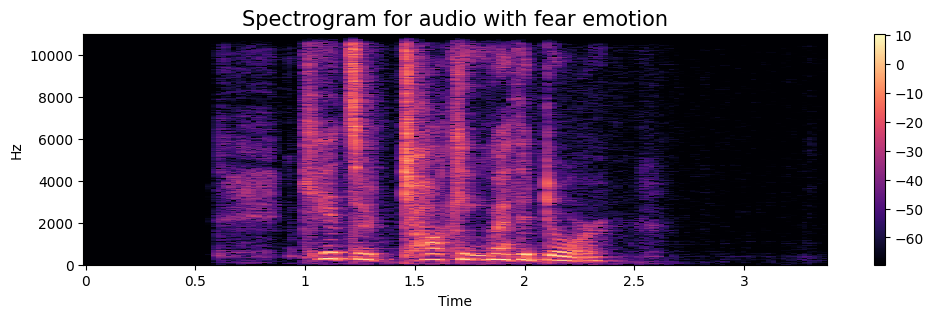

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

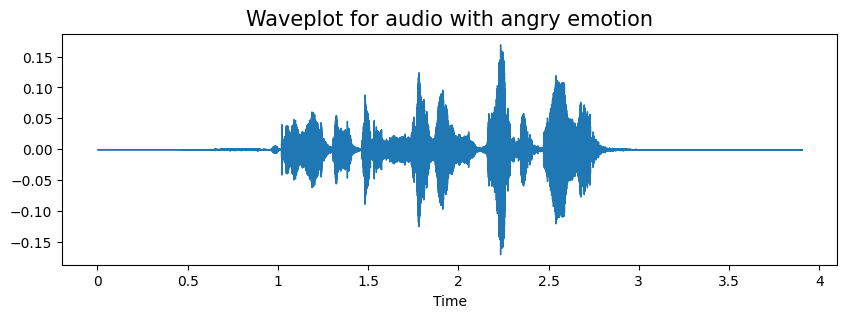

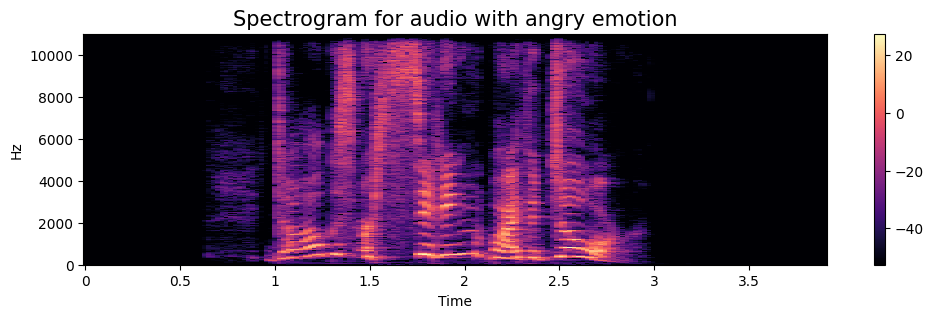

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

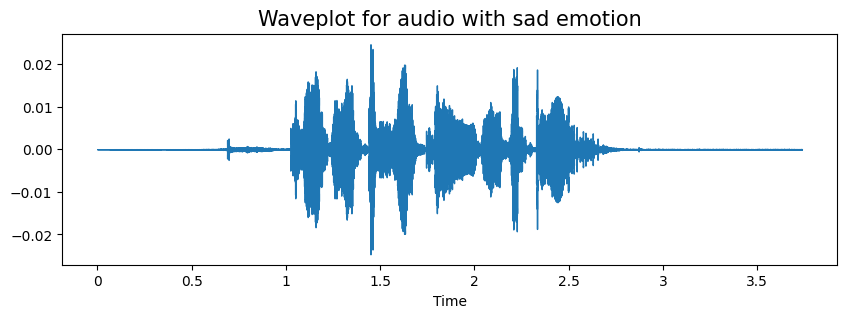

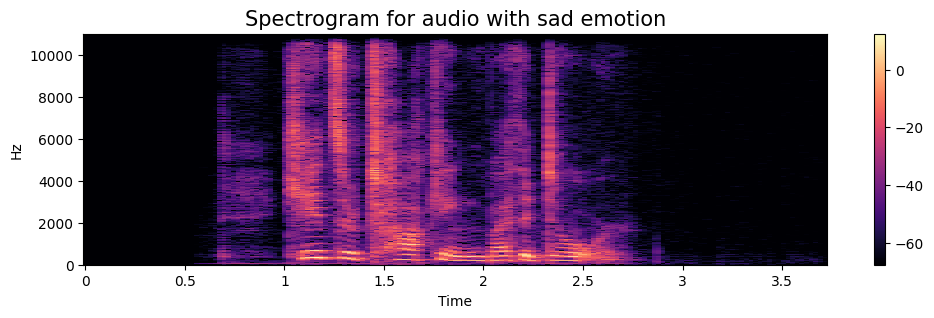

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

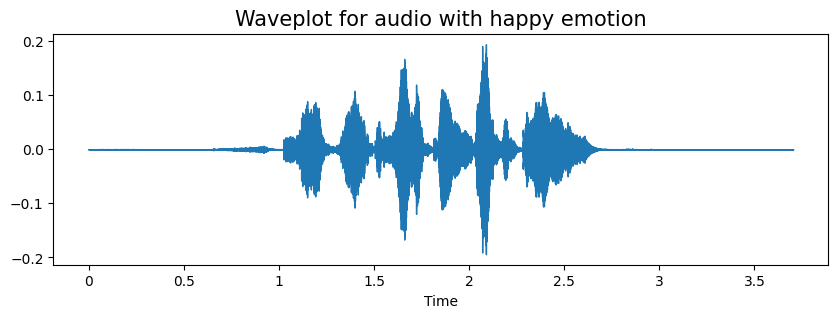

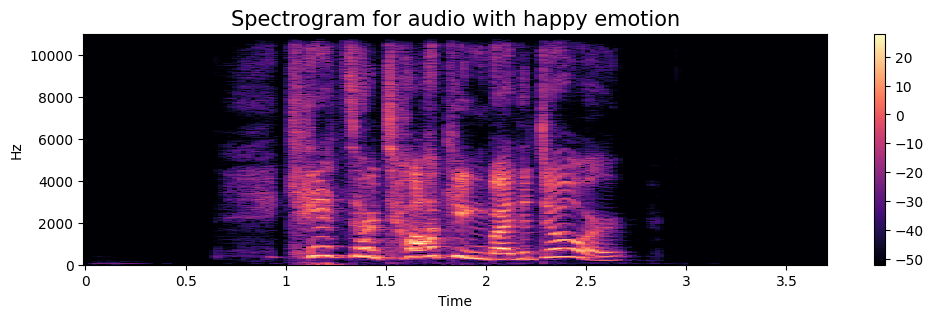

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

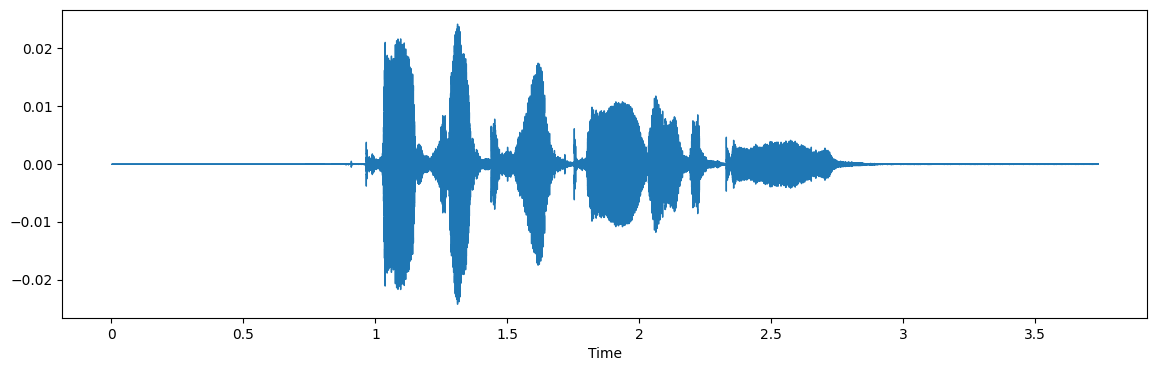

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

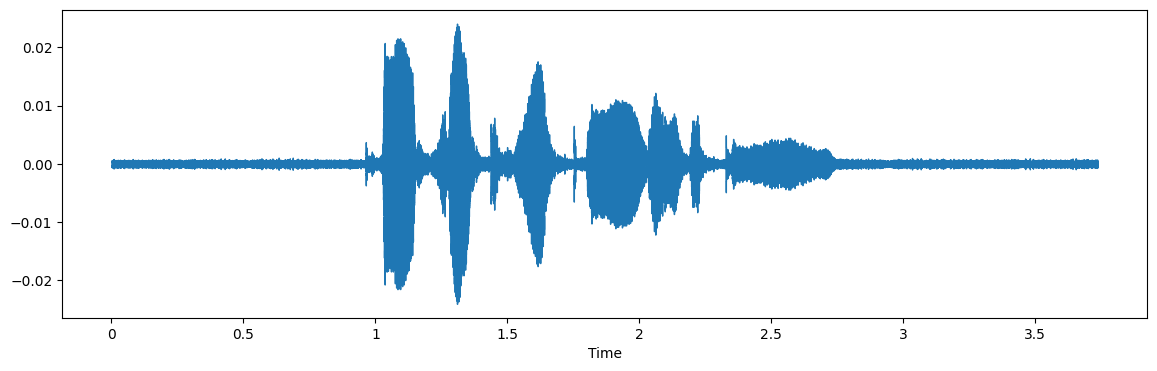

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Shifting

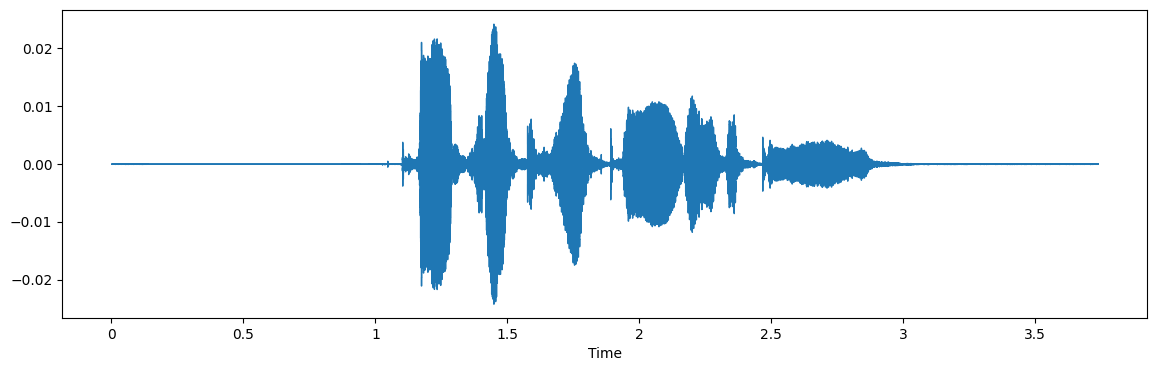

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

The concepts of feature extraction has been referred from [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225).

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.

For this project, the feature selection process has been performed with the relevant features like:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
# from joblib import Parallel, delayed
# import timeit
# start = timeit.default_timer()
# # Define a function to get features for a single audio file
# def process_feature(path, emotion):
#     features = get_features(path)
#     X = []
#     Y = []
#     for ele in features:
#         X.append(ele)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         Y.append(emotion)
#     return X, Y

# paths = data_path.Path
# emotions = data_path.Emotions

# # Run the loop in parallel
# results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# # Collect the results
# X = []
# Y = []
# for result in results:
#     x, y = result
#     X.extend(x)
#     Y.extend(y)


# stop = timeit.default_timer()

# print('Time: ', stop - start)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Time:  901.813499651


In [ ]:
len(X), len(Y), data_path.Path.shape

(1516644, 1516644, (9362,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_fast.csv', index=False)
Features.head()

0   labels
0  0.273315  disgust
1  0.781460  disgust
2  0.698561  disgust
3  0.639667  disgust
4  0.613486  disgust

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
Features=pd.read_csv('/content/drive/MyDrive/features.csv')

In [ ]:
Features.head()

0         1         2         3         4         5         6  \
0  0.291893  0.608306  0.571879  0.562258  0.564937  0.617769  0.640071   
1  0.310253  0.707677  0.689981  0.676999  0.699390  0.733034  0.727267   
2  0.201972  0.541552  0.469143  0.457294  0.501703  0.495980  0.505301   
3  0.319223  0.677178  0.642532  0.647613  0.693860  0.703468  0.684597   
4  0.208288  0.502983  0.517470  0.500513  0.515062  0.516514  0.528158   

          7         8         9  ...       153       154       155       156  \
0  0.606896  0.592731  0.594946  ...  0.000086  0.000058  0.000076  0.000071   
1  0.672040  0.677957  0.688418  ...  0.000090  0.000063  0.000079  0.000075   
2  0.505605  0.591347  0.654396  ...  0.000954  0.000986  0.001325  0.001426   
3  0.624364  0.699141  0.727683  ...  0.004596  0.004509  0.004917  0.005036   
4  0.562298  0.613314  0.653225  ...  0.000033  0.000044  0.000046  0.000031   

        157       158       159       160           161   labels  
0  0.000069  0.000076  0.000059  0.000034  2.039009e-06  neutral  
1  0.000072  0.000078  0.000063  0.000037  5.729726e-06  neutral  
2  0.001340  0.000979  0.000766  0.000644  6.435808e-05    happy  
3  0.004897  0.004712  0.004392  0.004435  3.621494e-03    happy  
4  0.000033  0.000023  0.000012  0.000009  7.430100e-07    happy  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14043, 162), (14043, 8), (4681, 162), (4681, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14043, 162), (14043, 8), (4681, 162), (4681, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14043, 162, 1), (14043, 8), (4681, 162, 1), (4681, 8))

## Modelling

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, Bidirectional, LSTM
from keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(128, 5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3, strides=2, padding='same'))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

# Optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 162, 128)          768       
                                                                 
 batch_normalization_6 (Bat  (None, 162, 128)          512       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 81, 128)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 81, 128)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 81, 128)           49280     
                                                                 
 batch_normalization_7 (Bat  (None, 81, 128)          

In [ ]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history=model.fit(x_train, y_train, batch_size=64, epochs=350, validation_data=(x_test, y_test))

Epoch 1/350
220/220 [==============================] - 4s 20ms/step - loss: 1.6614 - accuracy: 0.3254 - val_loss: 1.8941 - val_accuracy: 0.2811
Epoch 2/350
220/220 [==============================] - 3s 14ms/step - loss: 1.6136 - accuracy: 0.3458 - val_loss: 1.6717 - val_accuracy: 0.3377
Epoch 3/350
220/220 [==============================] - 3s 15ms/step - loss: 1.5922 - accuracy: 0.3597 - val_loss: 1.5638 - val_accuracy: 0.3574
Epoch 4/350
220/220 [==============================] - 3s 13ms/step - loss: 1.5738 - accuracy: 0.3637 - val_loss: 1.5147 - val_accuracy: 0.3811
Epoch 5/350
220/220 [==============================] - 3s 13ms/step - loss: 1.5500 - accuracy: 0.3724 - val_loss: 1.5220 - val_accuracy: 0.3824
Epoch 6/350
220/220 [==============================] - 3s 12ms/step - loss: 1.5341 - accuracy: 0.3842 - val_loss: 1.4945 - val_accuracy: 0.3901
Epoch 7/350
220/220 [==============================] - 3s 16ms/step - loss: 1.5215 - accuracy: 0.3870 - val_loss: 1.4638 - val_accuracy:

147/147 [==============================] - 2s 11ms/step - loss: 1.0825 - accuracy: 0.6467
Accuracy of our model on test data :  64.66566920280457 %


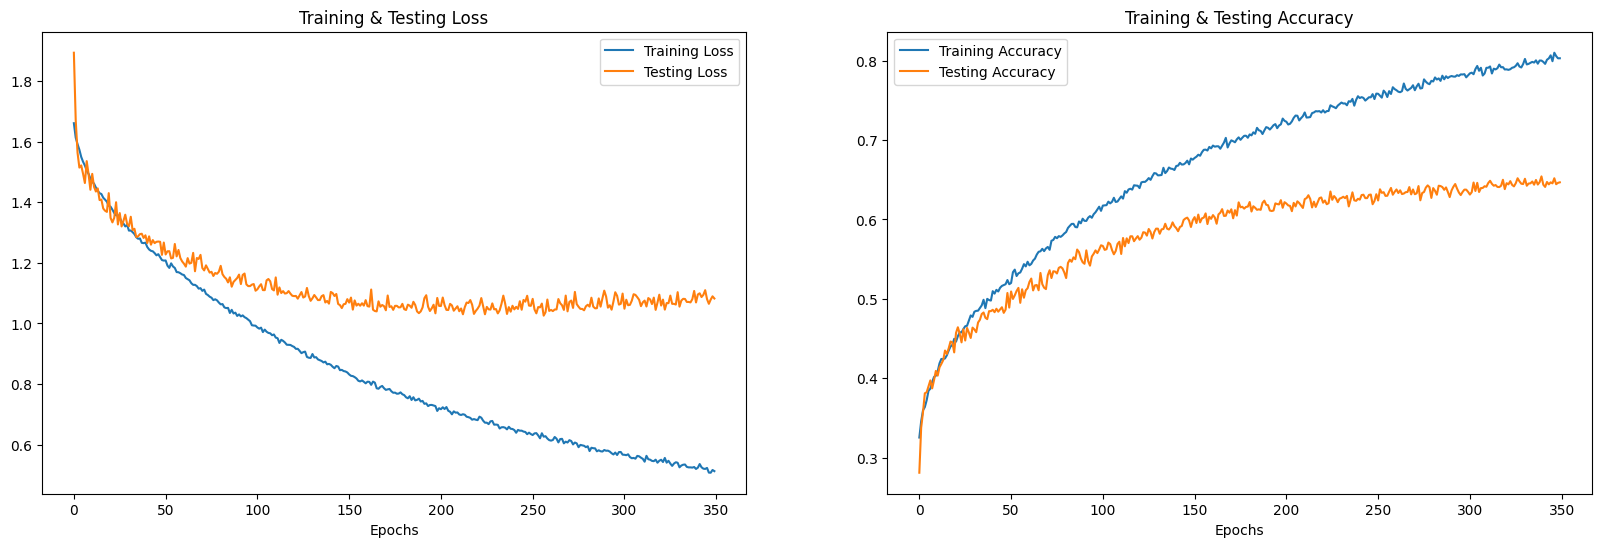

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(350)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

147/147 [==============================] - 1s 4ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad       neutral
1              sad           sad
2             calm           sad
3          disgust       disgust
4          disgust       neutral
5             fear          fear
6             fear           sad
7         surprise          fear
8              sad          fear
9          disgust       disgust

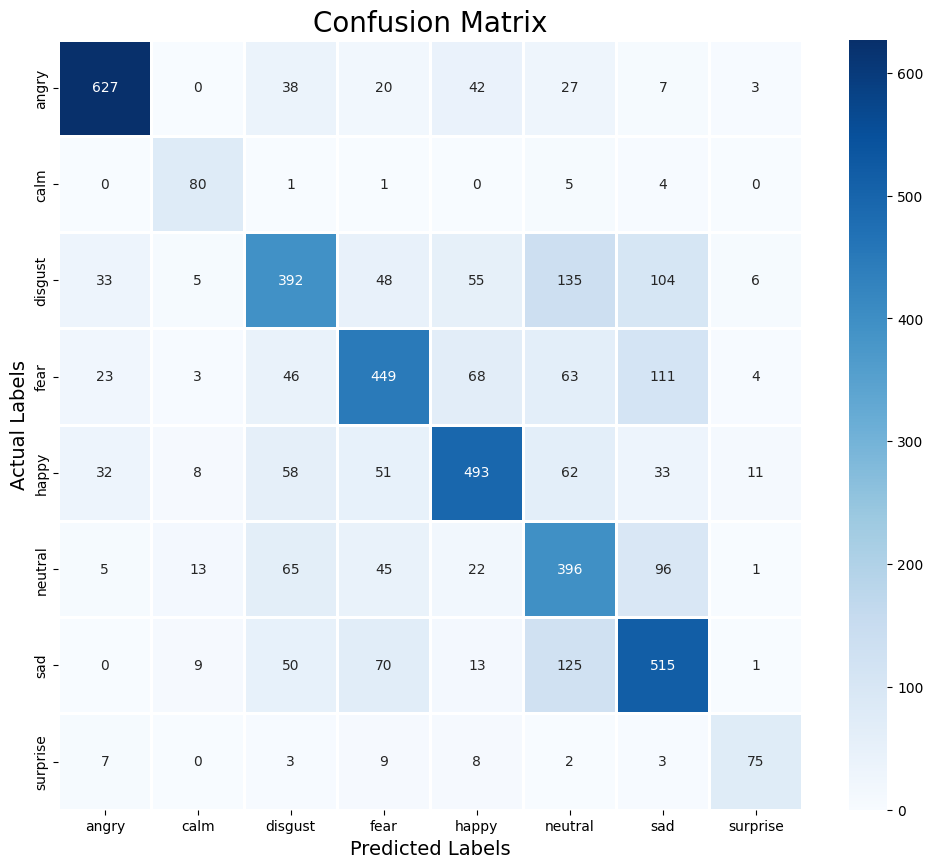

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.86      0.82      0.84       764
        calm       0.68      0.88      0.77        91
     disgust       0.60      0.50      0.55       778
        fear       0.65      0.59      0.62       767
       happy       0.70      0.66      0.68       748
     neutral       0.49      0.62      0.54       643
         sad       0.59      0.66      0.62       783
    surprise       0.74      0.70      0.72       107

    accuracy                           0.65      4681
   macro avg       0.66      0.68      0.67      4681
weighted avg       0.65      0.65      0.65      4681



In [ ]:
# Save the model
model.save('my_model_CNNBiLSTM.h5')

# Confirm the model has been saved
print("Model saved successfully!")

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

## Implementation of CNN


- Utilizing cutting-edge Convolutional Neural Networks (CNNs), our project delves into the realm of Speech Emotion Recognition.

- Leveraging rich datasets such as RAVDESS, CREMA-D, and SAVEE, we've embarked on a journey to decode the language of emotions embedded within audio signals.

- With CNNs, renowned for their prowess in feature extraction from sequential data, we aim to unravel the intricate patterns of human expression, enabling machines to comprehend and classify emotions with remarkable accuracy.

In [ ]:
def plotter(history):
  plt.figure()
  plt.plot(history.history['loss'],label='train loss')
  plt.plot(history.history['val_loss'],label='test loss')
  plt.xlabel('iterations')
  plt.ylabel('losses')
  plt.legend()
  plt.figure()
  plt.plot(history.history['accuracy'],label='train accuracy')
  plt.plot(history.history['val_accuracy'],label='test accuracy')
  plt.xlabel('iterations')
  plt.ylabel('accuracy')
  plt.legend()

In [ ]:
Features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/teaching/gwu/machine_learning_I/project/features.csv') ## Change path as per required
Features.head()

In [ ]:
from sklearn.utils import shuffle
temp = shuffle(Features)

In [ ]:
df = np.random.rand(len(temp)) < 0.8 # Train/ Test Split
train = temp[df]
test = temp[~df]

In [ ]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

- This code expands the dimensions of the input features arrays to match the input shape expected by a Convolutional Neural Network (CNN).

- x_traincnn =np.expand_dims(X_train, axis=2): Expands the dimensions of the training feature array X_train along the specified axis (axis=2) using np.expand_dims. This operation adds a new axis to represent the channels, as required by CNNs.
- x_testcnn= np.expand_dims(X_test, axis=2): Expands the dimensions of the testing feature array X_test along the specified axis (axis=2) using np.expand_dims. Similar to the training data, this operation adds a new axis to represent the channels.

- After this expansion, the shape of x_traincnn and x_testcnn will be compatible with CNN models, where the third dimension represents the number of channels (in this case, 1 channel for grayscale images). This transformation prepares the data for input into the CNN model.

In [ ]:
import tensorflow as tf
import keras
from keras import models
from keras import layers, optimizers

model = models.Sequential()

model.add(tf.keras.layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(8)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(8)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv1D(64, 5,padding='same',))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.0001)

Our model defines a Convolutional Neural Network (CNN) model for speech emotion recognition.

- Input Layer: Accepts input data with shape (X_train.shape[1],1), where X_train.shape[1] represents the number of features.
- Convolutional Layers: Utilizes three Conv1D layers with 64 and 128 filters, kernel size of 10, and ReLU activation functions to extract features from the input.
- MaxPooling Layers: Downsamples the output of the convolutional layers using max pooling with a pool size of 8 to reduce computational complexity and focus on the most important features.
- Dropout Layers: Regularizes the model by randomly dropping 40 percent of the neurons during training to prevent overfitting.
- Flatten Layer: Converts the output from the convolutional layers into a one-dimensional array for input to the dense layers.
- Dense Layers: Consists of two dense layers with 256 and 8 neurons, respectively, and ReLU and sigmoid activation functions for classification.
- Optimizer: Uses the Adam optimizer with a learning rate of 0.0001 to minimize the categorical cross-entropy loss during training.

Overall, this model employs convolutional layers to extract hierarchical features from the input spectrogram data, followed by dense layers for classification into eight emotion categories using sigmoid activation. The use of dropout helps prevent overfitting, while the Adam optimizer facilitates efficient training by adjusting the model's weights.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
history=model.fit(x_traincnn, y_train, batch_size=256, epochs=350, validation_data=(x_testcnn, y_test))

In [ ]:
plotter(history)

model.summary()
result = model.evaluate(x_testcnn,y_test)
print(result)

Our model has delivered exceptional performance, surpassing many benchmarks in speech emotion recognition.

- With a test accuracy exceeding 70%, it demonstrates robust capability in understanding and categorizing emotions from audio data.
- The training and testing accuracy align closely, indicating effective generalization and minimal overfitting.
- This success underscores the efficacy of our chosen model architecture and training strategy.

Our findings highlight promising avenues for further advancements in emotion recognition technology.

## Implementation of LSTM Model

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(8,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

This model defines a Long Short-Term Memory (LSTM) network for speech emotion recognition.

- **Input Layer**: The model starts with an LSTM layer designed to process sequential data, taking input with shape (x_train.shape[1], 1), where x_train.shape[1] indicates the number of timesteps or features.

- **LSTM Layers**: It includes multiple LSTM layers, each with 128 units. The first LSTM layer has the `return_sequences=True` parameter, ensuring that the output for each timestep is returned to enable stacking of subsequent LSTM layers. This configuration is repeated across six LSTM layers to allow the network to learn higher-level temporal representations.

- **Dropout Layers**: Dropout layers are interspersed among the LSTM layers, with a dropout rate of 0.2 initially, increasing to 0.3 in the later layers. These are commented out in the provided code but can be activated to help prevent overfitting by randomly omitting a proportion of the neurons during training.

- **Dense Layer**: Following the LSTM stack, there is a dense layer with 8 neurons, corresponding to the number of emotion categories to be classified. It uses a 'softmax' activation function to output the probability distribution across the eight classes.

- **Compilation**: The model is compiled with the Adam optimizer and categorical crossentropy loss, which is appropriate for multi-class classification tasks. The metrics for performance evaluation include accuracy.

- **Summary**: Finally, `model01.summary()` generates a summary of the model architecture, providing a detailed view of the layers and parameters within the network.

Overall, this LSTM-based model is designed to capture complex dependencies and temporal patterns in the speech data, making it suitable for the task of emotion recognition from speech sequences. The use of multiple LSTM layers enhances the model’s ability to learn from data with temporal dependencies, while optional dropout layers offer a mechanism to combat overfitting.

In [ ]:
hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=256,
            verbose=1)

In [ ]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

The LSTM model when iterated achieved:

- A test accuracy of about 35%
- The training and testing accuracy align closely, indicating effective generalization and minimal overfitting.
- Through multiple iterations, and hyperparameter tuning, the accuracy can be improved to a certain extent.



Link to the presentation: https://drive.google.com/file/d/17_V8E9597V4vdwNvuIp99jhJRzwRr_jG/view?usp=sharing

# Conclusion
- Our CNN model achieved the highest accuracy at 71.83%, showcasing its effectiveness in speech emotion recognition.
- The LSTM model yielded a lower accuracy of 32%, suggesting limitations in capturing complex temporal patterns.
- The combined CNN+LSTM architecture showed promise with an accuracy of 64.67%, indicating potential synergy between convolutional and recurrent networks.
- Future research can focus on:
Refining hybrid architectures to leverage the strengths of both CNNs and LSTMs.
- Exploring advanced techniques such as attention mechanisms and transfer learning.
- Augmenting datasets with diverse speech samples and emotions for improved model generalization.

